In [2]:
# Which of our runs has the largest UHI? 

# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

from netCDF4 import Dataset
from wrf import getvar
import wrf
from wrf import ALL_TIMES
#### 

import scipy.stats
# define plots
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

plt.style.use('ggplot')
# read in temp data 
filepath = '../cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')

rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')
rhDF.columns = rhDF.columns.astype('int')

urban = 86 #97 # science center
rural = 4 #68 # darryn's house


# classify dry days and wet days and do again 
file = '/Users/ascott47/blausteinmount/heat/data/synopticclassification/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:84: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:87: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


# Feb 7: Look at how temperature, UHI varies over time 
## taking into account spatial variability, for different spatial resolution
Look at temp (tu, tr, t1u, t1r, t2u, t2r, T2m_u, T2m_r, TSK...) and DT at 6am, 4pm
-make urban/rural a multi index column? 

In [2]:
urban = 86 #97 # science center
rural = 4 #68 # darryn's house
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points.index = ['urban', 'rural']
# pick a random rural point for analysis
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

In [13]:
# make dataframe
variables = ['T2', 'TSK']
exp = 'UCM+SST'
dom = 'd03'
fpath = '/Users/ascott47/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
hours = [6,16]
cols = hours#['6am', '4pm']#, 'UHI_max', 'UHI_min', 'date']
for file in files[hr+4::24]:
        test_list.append(Dataset(file))
df = getvar(test_list, varname = var, 
                      timeidx = wrf.ALL_TIMES, 
                      method = 'cat'
                   )
df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
iterables = [['d01', 'd02','d03'],df.Time.values]
col_iterables = [hours, variables]
urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['hour', 'variable']), dtype= float32)
rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time']), 
                     columns=pd.MultiIndex.from_product(col_iterables, names = ['hour', 'variable']))
# urban_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time', 'variables']),
#                      columns=cols)
# rural_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['domain', 'time', 'variables']),
#                      columns=cols)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 1048, in getinnerframes
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 1008, in getframeinfo
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 453, in getsourcefile
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 482, in getmodule
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/inspect.py", line 466, in getabsfile
  File "/Users/ascott47/anaconda/envs/python2/lib/python2.7/posixpath.py", line 364, in 

IndexError: string index out of range

In [5]:
## run in ipython

variables = ['T2', 'TSK']
#exp = 'UCM+SST'
exp = 'UCM'

dom = 'd03'
fpath = '/Users/ascott47/mountpoint/wrf/out/'
files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))

idx = pd.IndexSlice
for exp in ['UCM', 'UCM+SST']:
    for dom in ['d01', 'd02', 'd03'] :  
        hours = [6,16]
        for hr in hours : 
            files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
            pts = wrf.ll_to_xy(Dataset(files[-1]),analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            counter = 0
            test_list = []
            for file in files[hr+4::24]:
                test_list.append(Dataset(file))
                counter = counter+1

            for var in variables:     
                df = getvar(test_list, varname = var, 
                              timeidx = wrf.ALL_TIMES, 
                              method = 'cat'
                           )

                df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
                urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
                rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
                urban_df.loc[dom, idx[hr, var]] = urban.to_pandas().values
                rural_df.loc[dom, idx[hr, var]] = rural.to_pandas().values

                df.close()
                del df
            del test_list
urban_df.to_csv('data/urban_%s.csv'%exp)
rural_df.to_csv('data/rural_%s.csv'%exp)

NameError: name 'analysis_points' is not defined

In [123]:
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime

urban_df = pd.read_csv('data/urban_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True).subtract(273.15)
urban_df.index = urban_df.index.set_levels([urban_df.index.levels[0], pd.to_datetime(urban_df.index.levels[1])])


rural_df = pd.read_csv('data/rural_%s.csv'%exp, 
                       index_col=[0,1], 
                       header = [0,1], 
                       # parse_dates = ['time'], date_parser = date_parser,
                       skipinitialspace=True).subtract(273.15)
rural_df.index = rural_df.index.set_levels([rural_df.index.levels[0], pd.to_datetime(rural_df.index.levels[1])])

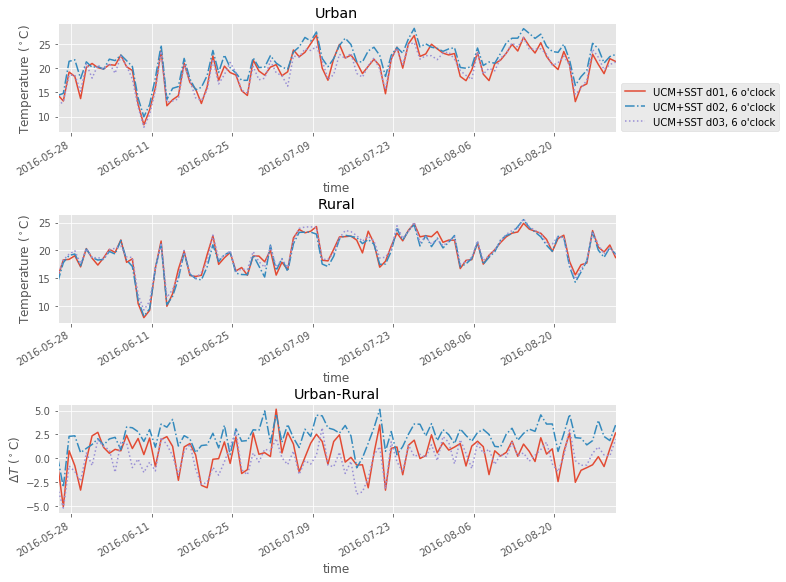

In [128]:
# plot by time 
dom = 'd01' 
var = 'T2'
hr = 6

fig = plt.figure(figsize = [10,10])
for dom, linestyle in zip(['d01', 'd02', 'd03'], ['-', '-.', ':']) : 
    ax = plt.subplot(3,1,1)
    urban_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot(ax=ax, linestyle = linestyle, label = '%s %s, %s o\'clock'%(exp, dom, hr))
    ax.set_title('Urban')
    ax.set_ylabel('Temperature ($^\circ$C)')
    ax = plt.subplot(3,1,2)
    rural_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot(ax=ax, linestyle = linestyle)
    ax.set_title('Rural')
    ax.set_ylabel('Temperature ($^\circ$C)') 
    ax = plt.subplot(3,1,3)
    (urban_df-rural_df).loc[dom].loc[(slice(None),'%s'%hr)][var].plot(ax=ax, linestyle = linestyle)
    ax.set_title('Urban-Rural')
    ax.set_ylabel('$\Delta T$ ($^\circ$C)')
    
plt.subplot(3,1,1).legend(bbox_to_anchor=(1, .5) )
plt.subplots_adjust(hspace=0.75)

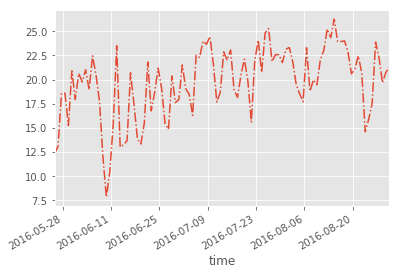

In [120]:
urban_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot(linestyle = '-.')

In [87]:
urban_df = pd.read_csv('data/urban.csv', index_col=[0,1], 
                       header = [0,1], 
                       skipinitialspace=True).subtract(273.15)
rural_df = pd.read_csv('data/urban.csv', index_col=[0,1], 
                       header = [0,1], 
                       skipinitialspace=True).subtract(273.15)

In [23]:
urban_df.head()

hour                                 6                      16            
variable                            T2         TSK          T2         TSK
domain time                                                               
d01    2016-05-25 16:00:00  285.451782  284.474518  302.477631  305.552856
       2016-05-26 16:00:00  286.250763  286.356140  303.818176  306.773621
       2016-05-27 16:00:00  291.687836  291.712341  297.271027  297.451843
       2016-05-28 16:00:00  291.730072  291.797150  304.938812  308.008301
       2016-05-29 16:00:00  288.388580  288.787781  302.969604  306.718750

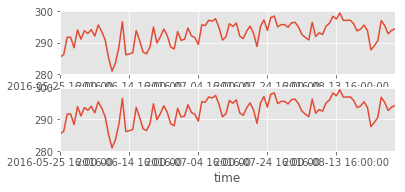

In [86]:
# plot by time 
fig = plt.figure()
ax = plt.subplot(3,1,1)
urban_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot()
ax = plt.subplot(3,1,2)
urban_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot()

# ax = plt.subplots(312)
# rural_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot(ax=ax)

In [66]:
urban_df.loc[dom].loc[(slice(None), '6')]

variable,T2,TSK
time,,
2016-05-25 16:00:00,285.451782,284.474518
2016-05-26 16:00:00,286.250763,286.356140
2016-05-27 16:00:00,291.687836,291.712341
2016-05-28 16:00:00,291.730072,291.797150
2016-05-29 16:00:00,288.388580,288.787781
2016-05-30 16:00:00,294.048096,294.563385
2016-05-31 16:00:00,291.102142,291.355347
2016-06-01 16:00:00,293.780579,294.329590
2016-06-02 16:00:00,292.905243,293.324951


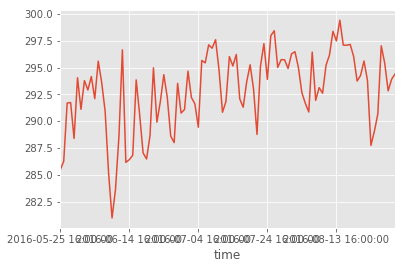

In [81]:
urban_df.loc[dom].loc[(slice(None),'%s'%hr)][var].plot()

In [45]:
dom = 'd01' 
var = 'T2'
hr = 6
idx = pd.IndexSlice
urban_df.loc[idx[dom,:]]

hour                          6                      16            
variable                     T2         TSK          T2         TSK
time                                                               
2016-05-25 16:00:00  285.451782  284.474518  302.477631  305.552856
2016-05-26 16:00:00  286.250763  286.356140  303.818176  306.773621
2016-05-27 16:00:00  291.687836  291.712341  297.271027  297.451843
2016-05-28 16:00:00  291.730072  291.797150  304.938812  308.008301
2016-05-29 16:00:00  288.388580  288.787781  302.969604  306.718750
2016-05-30 16:00:00  294.048096  294.563385  299.856842  303.525330
2016-05-31 16:00:00  291.102142  291.355347  303.778046  307.509888
2016-06-01 16:00:00  293.780579  294.329590  301.853180  304.232300
2016-06-02 16:00:00  292.905243  293.324951  301.285706  305.843018
2016-06-03 16:00:00  294.163361  294.516174  300.525879  304.059814
2016-06-04 16:00:00  292.092896  292.253479  303.540253  307.855774
2016-06-05 16:00:00  295.602844  296.010498  301.406006  305.522675
2016-06-06 16:00:00  293.603546  292.982300  303.533020  306.539490
2016-06-07 16:00:00  290.922058  291.039001  302.599701  305.207550
2016-06-08 16:00:00  285.165802  285.353394  294.449615  297.955780
2016-06-09 16:00:00  280.968964  281.059509  298.040863  301.194397
2016-06-10 16:00:00  283.627838  283.443573  299.031982  302.678009
2016-06-11 16:00:00  288.581268  288.769379  308.103577  310.180115
2016-06-12 16:00:00  296.650238  295.842224  304.680298  307.254761
2016-06-13 16:00:00  286.156250  285.712280  298.231689  302.824402
2016-06-14 16:00:00  286.399963  286.645355  298.551819  303.460266
2016-06-15 16:00:00  286.816071  287.253845  301.629974  305.861450
2016-06-16 16:00:00  293.845337  294.162476  301.149353  304.047821
2016-06-17 16:00:00  290.605927  290.852783  299.419983  303.626251
2016-06-18 16:00:00  287.024872  287.136841  300.380127  304.553589
2016-06-19 16:00:00  286.470825  286.767517  303.202148  307.270203
2016-06-20 16:00:00  288.640625  288.806641  305.883850  309.120667
2016-06-21 16:00:00  294.971527  294.968903  306.349030  309.736877
2016-06-22 16:00:00  289.904266  290.249878  303.588623  306.572571
2016-06-23 16:00:00  291.829468  292.204224  297.271790  299.619019
...                         ...         ...         ...         ...
2016-08-01 16:00:00  296.478180  296.646515  299.758911  304.107849
2016-08-02 16:00:00  294.990906  295.075195  305.209412  310.125641
2016-08-03 16:00:00  292.647064  292.332397  303.063538  308.366669
2016-08-04 16:00:00  291.665283  291.605469  303.705719  308.799683
2016-08-05 16:00:00  290.854858  291.226898  304.572754  309.610535
2016-08-06 16:00:00  296.440796  296.289001  309.635376  313.895996
2016-08-07 16:00:00  291.939270  291.472107  306.443665  310.403839
2016-08-08 16:00:00  293.124939  292.683228  305.570312  310.836243
2016-08-09 16:00:00  292.604370  292.804199  300.087067  301.379028
2016-08-10 16:00:00  295.213654  295.440094  308.343750  311.596802
2016-08-11 16:00:00  296.173889  296.308533  310.386383  314.639404
2016-08-12 16:00:00  298.381287  298.073303  310.495148  315.095642
2016-08-13 16:00:00  297.484863  297.879791  307.843262  311.563904
2016-08-14 16:00:00  299.412903  299.357117  306.828400  308.800232
2016-08-15 16:00:00  297.090118  297.366028  305.927032  311.883606
2016-08-16 16:00:00  297.083313  297.387878  304.612640  304.887024
2016-08-17 16:00:00  297.153290  296.827179  308.406403  312.866943
2016-08-18 16:00:00  296.033630  296.617188  302.692352  306.975708
2016-08-19 16:00:00  293.742645  294.154114  306.950104  311.446960
2016-08-20 16:00:00  294.253418  294.118744  305.172485  310.129425
2016-08-21 16:00:00  295.607971  295.840271  299.974670  303.659454
2016-08-22 16:00:00  293.806396  292.689636  302.272888  305.748535
2016-08-23 16:00:00  287.735107  287.361908  301.121735  305.832947
2016-08-24 16:00:00  289.035004  289.040283  303.287750  307.060028
2016-08-25 16:00:00  290.665741  290.778748  308.060547 

In [ ]:
dom = 'd01' 
var = 'T2'
plt.plot(urban_df.loc[dom, var])

In [ ]:
# to finish: add point variation, make plot of temperatures 

In [ ]:
urban_df.tail()

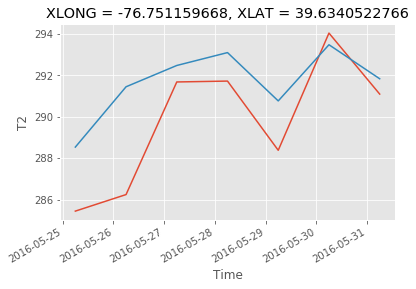

In [28]:
urban.plot()
rural.plot()

# Feb 1: look at how UHI varies with model resolution

In [3]:
index = []
fpath = '/Users/ascott47/mountpoint/wrf/out/'
dirs = os.listdir(fpath)
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))
        if files: 
            print(exp,dom, " contains %i files"%len(files))
            index.append('%s_%s'%(exp,dom))

('UCM2D', 'd01', ' contains 2353 files')
('UCM2D', 'd02', ' contains 1449 files')
('UCM', 'd01', ' contains 2353 files')
('UCM', 'd02', ' contains 2353 files')
('UCM', 'd03', ' contains 196 files')
('UCM2D+SST', 'd01', ' contains 2353 files')
('UCM2D+SST', 'd02', ' contains 1447 files')
('UCM+SST', 'd01', ' contains 2353 files')
('UCM+SST', 'd02', ' contains 2353 files')
('UCM+SST', 'd03', ' contains 2353 files')


In [4]:
dirs = os.listdir('/Users/ascott47/mountpoint/wrf/run/2way/')
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/2way/%s/wrfout_%s*'%(exp,dom))))
        #files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/%s/wrfout_%s*'%(exp,dom))))
        if files: 
            print(exp,dom, " contains %i files"%len(files))
            index.append('%s_%s'%(exp,dom))

('BEM2D+SST', 'd01', ' contains 61 files')
('BEM2D+SST', 'd02', ' contains 61 files')
('BEM2D+SST', 'd03', ' contains 61 files')


In [40]:
# cols = ['UHI_6am', 'UHI_4pm', 'UHI_max', 'UHI_min']
# uhidf = pd.DataFrame(index = index, columns=cols)
uhidf = pd.read_csv('uhi_analysis.csv').set_index('Unnamed: 0')
uhidf.loc['BEM2D+SST_d01'] = np.ones(uhidf.shape[1])*np.nan
uhidf.loc['BEM2D+SST_d02'] = np.ones(uhidf.shape[1])*np.nan
uhidf.loc['BEM2D+SST_d03'] = np.ones(uhidf.shape[1])*np.nan

In [7]:
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points = meta.loc[[urban,rural]][['location:Longitude', 'location:Latitude']]
analysis_points.index = ['urban', 'rural']
# pick a random rural point for analysis
analysis_points.loc['rural', 'location:Longitude'] = -76.752754
analysis_points.loc['rural', 'location:Latitude']  = 39.637964

('UCM2D', 'd01')
('UCM2D', 'd02')
('UCM2D', 'd03')
No data for UCM2D d03
('BEM2D+SST', 'd01')
No data for BEM2D+SST d01
('BEM2D+SST', 'd02')
No data for BEM2D+SST d02
('BEM2D+SST', 'd03')
No data for BEM2D+SST d03
('BEM2D', 'd01')
No data for BEM2D d01
('BEM2D', 'd02')
No data for BEM2D d02
('BEM2D', 'd03')
No data for BEM2D d03
('UCM', 'd01')
('UCM', 'd02')
('UCM', 'd03')
('BEM+SST', 'd01')
No data for BEM+SST d01
('BEM+SST', 'd02')
No data for BEM+SST d02
('BEM+SST', 'd03')
No data for BEM+SST d03
('BEM', 'd01')
No data for BEM d01
('BEM', 'd02')
No data for BEM d02
('BEM', 'd03')
No data for BEM d03
('UCM2D+SST', 'd01')
('UCM2D+SST', 'd02')
('UCM2D+SST', 'd03')
No data for UCM2D+SST d03
('UCM+SST', 'd01')
('UCM+SST', 'd02')
('UCM+SST', 'd03')


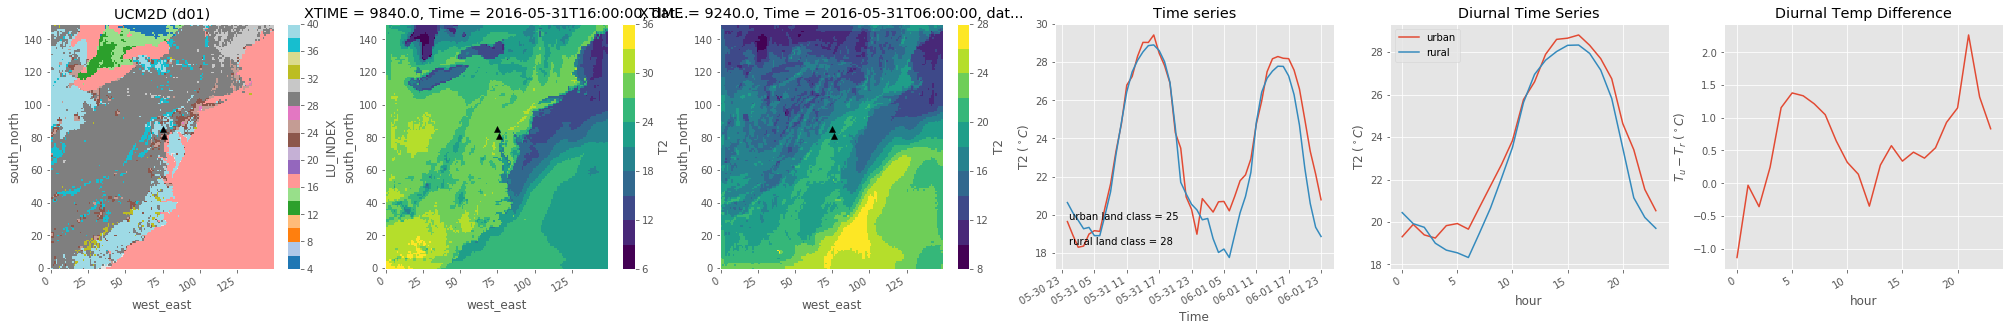

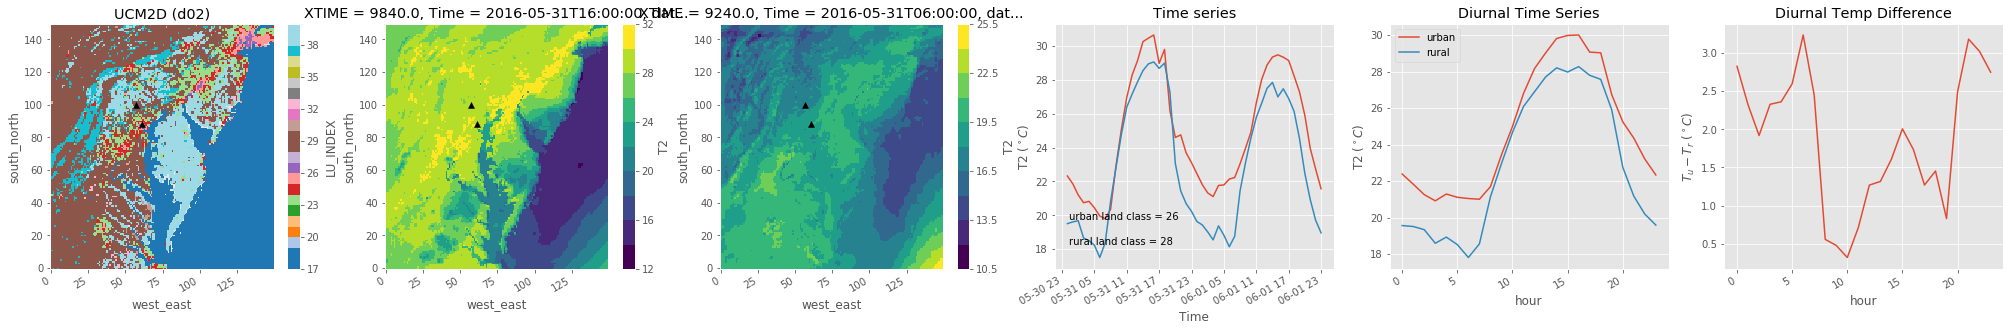

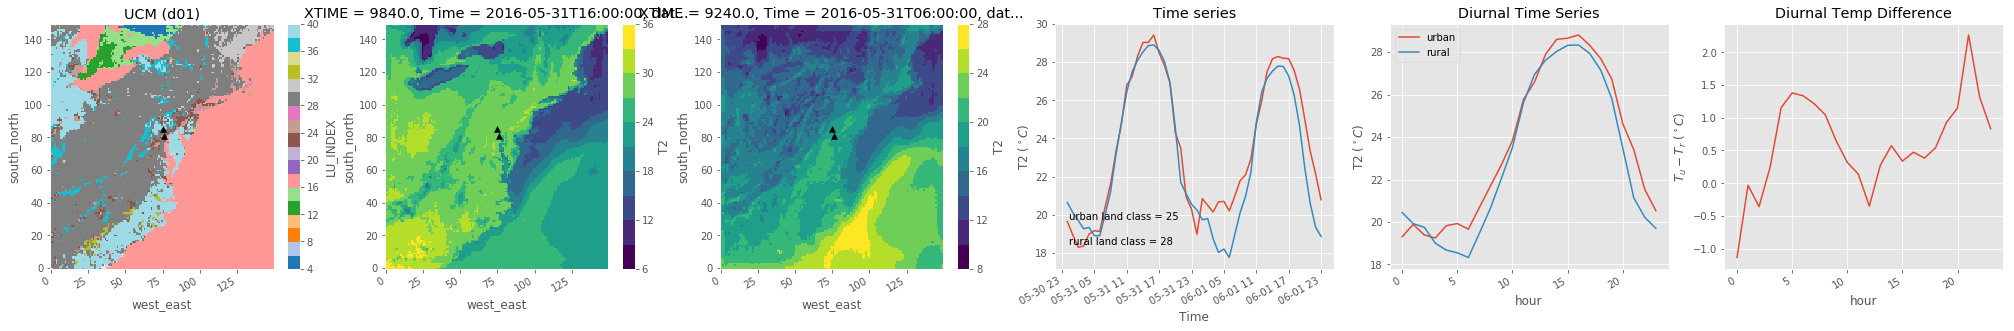

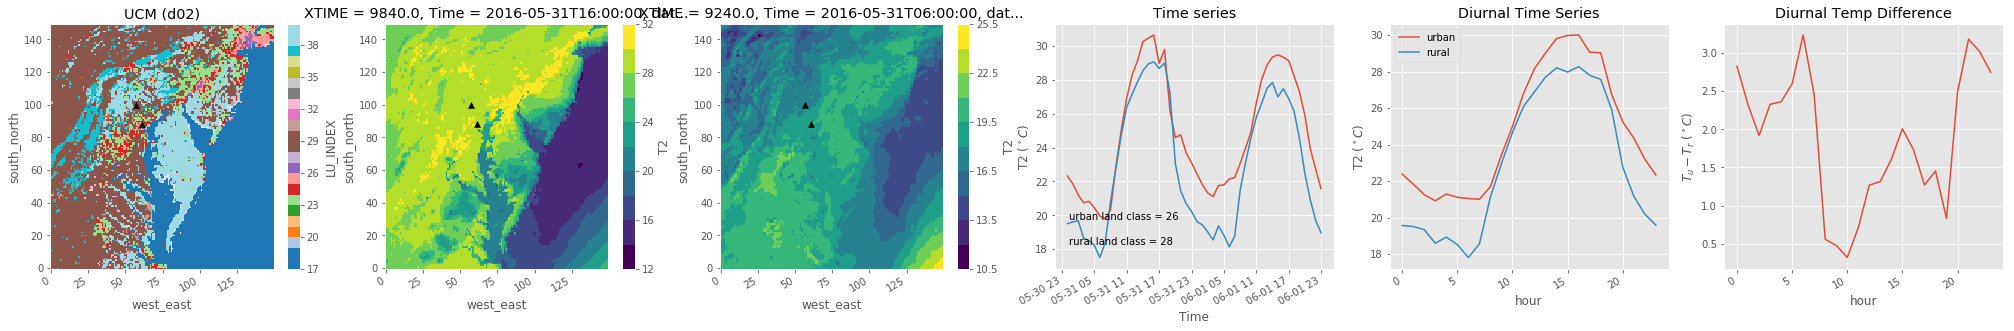

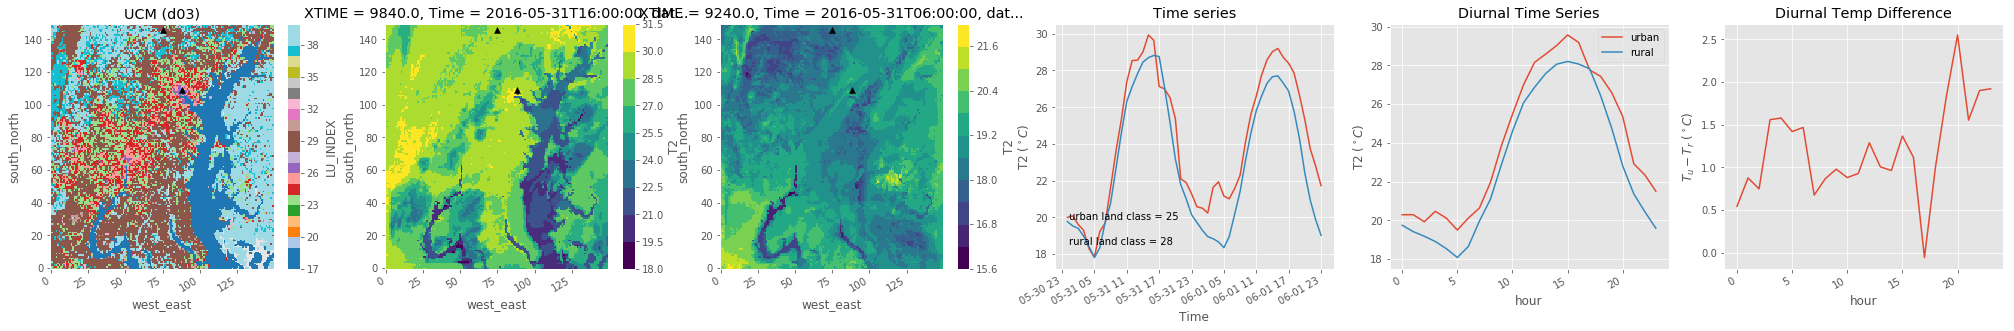

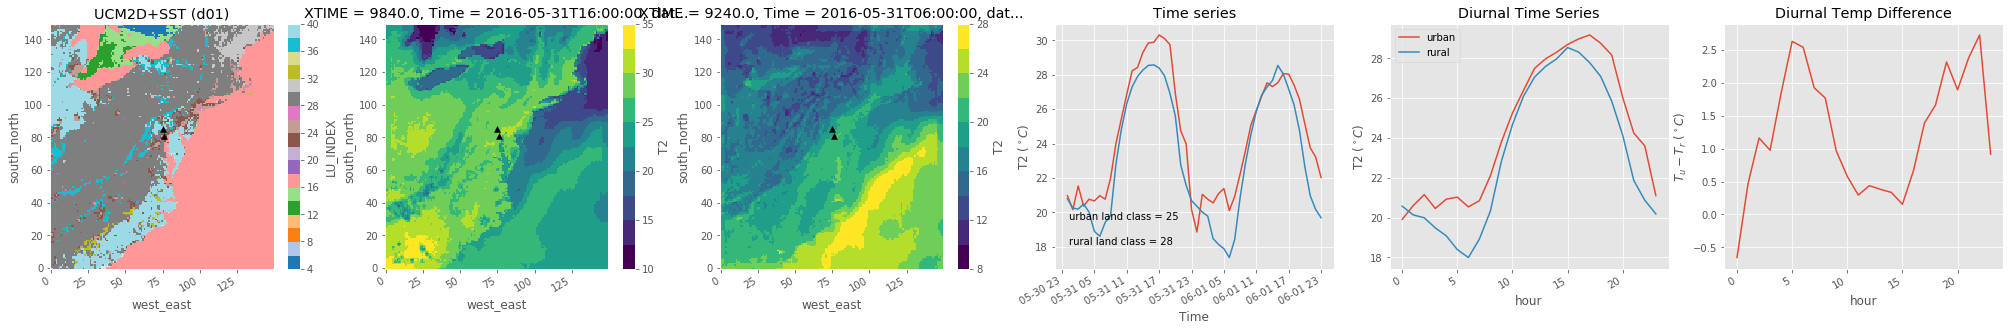

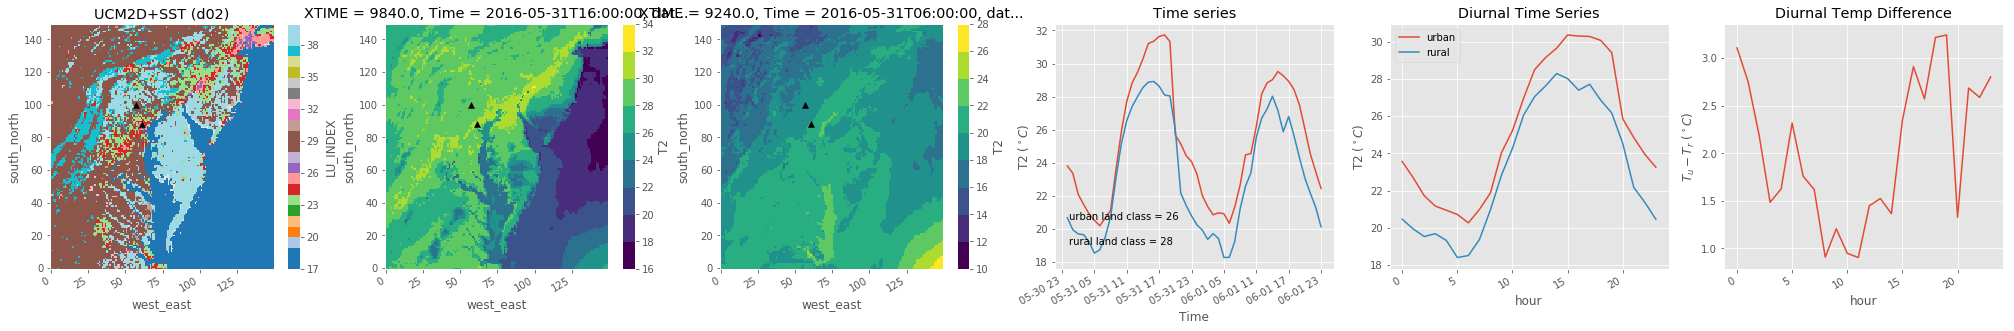

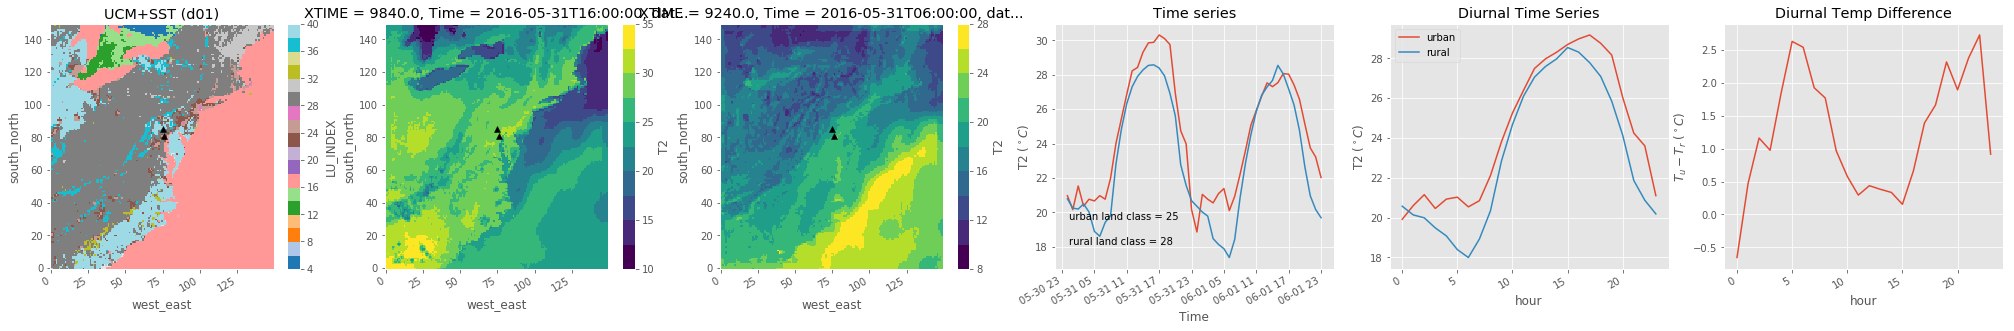

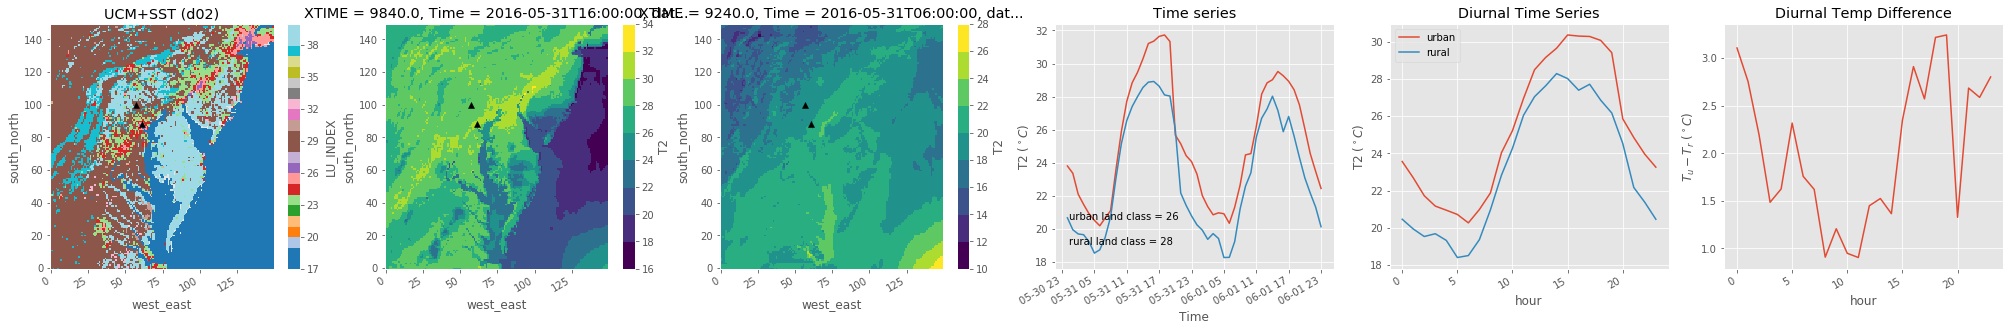

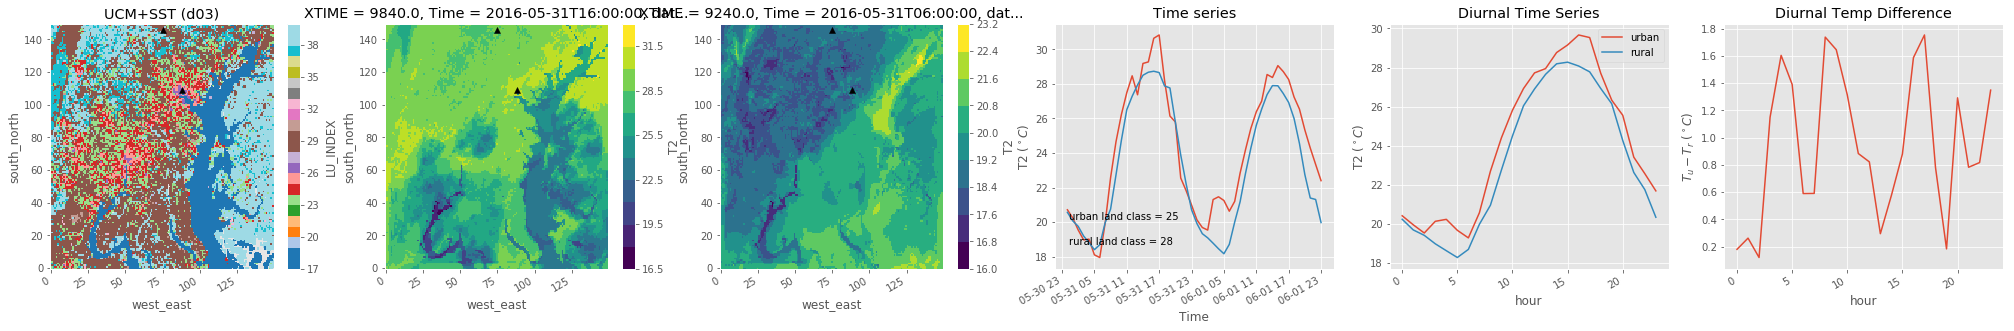

In [79]:
# loop 
fpath = '/Users/ascott47/mountpoint/wrf/out/'
dirs = os.listdir(fpath)
# dirs =  ['BEM2D+SST',
#  'BEM2D',
#  'UCM',
#  'BEM+SST',
#  'BEM',
#  'UCM2D+SST',
#  'UCM+SST']
date = '2016-05-31'
cols = ['UHI_6am', 'UHI_4pm', 'UHI_max', 'UHI_min', 'date']
uhidf = pd.DataFrame(index = index, columns=cols)

pts =pd.DataFrame([ [85,87],#west_east
                   [140, 109] ]) # south_north
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        #files = list(np.sort(glob.glob(fpath + '%s/wrfout_%s*'%(exp,dom))))
        files = list(np.sort(glob.glob(fpath + '%s/%s/wrfout_d01*'%(exp,dom))))

        print(exp,dom)
        
        if files: 
            test_list = []
            for file in files[148:196]:
                test_list.append(Dataset(file))
            df = getvar(test_list, varname = "T2", 
                          timeidx = wrf.ALL_TIMES, 
                          method = 'cat'
                          )
            # convert to degrees C
            df = df - 273.15
            # convert to local time
            df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            # points[0] is the lat coordinates
            # points[1] is the lon coordinate
            # urban, rural
            fig, axes = plt.subplots(ncols=6, figsize = [35,5])
            i = 0
            # plot landcover
            lc = getvar(test_list[-1], "LU_INDEX")
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            lc.plot(levels = 24, cmap  = cm.tab20, ax = axes[i])
            axes[i].set_title('%s (%s)'%(exp, dom))
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map day 
            try: 
                df.sel(Time = date +'T16:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-07-24' +'T16:00:00').plot(ax = axes[i], levels = 11)
            #axes[i].set_title('Night (%s 4am)'%date)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map night 
            try: 
                df.sel(Time = date+'T6:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-07-24' +'T6:00:00').plot(ax = axes[i], levels = 11)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # plot temp time series
    #         urban = df.isel(south_north= points.values[0][0], west_east = points.values[1][0])
    #         rural = df.isel(south_north= points.values[0][1], west_east = points.values[1][1])
            urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
            rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
            urban_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[0,0]
            rural_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[1,1]
            urban.plot(ax = axes[i])
            rural.plot(ax = axes[i])
            axes[i].set_title('Time series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            axes[i].annotate('urban land class = %i'%urban_lc,( .05,.2), xycoords = 'axes fraction')
            axes[i].annotate('rural land class = %i'%rural_lc,( .05,.1), xycoords = 'axes fraction')
            i = i+1
            # plot diurnal temp cycle
            urban.groupby('Time.hour').mean().plot(ax = axes[i], label = 'urban')
            rural.groupby('Time.hour').mean().plot(ax = axes[i], label = 'rural')
            axes[i].legend()
            axes[i].set_title('Diurnal Time Series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            i = i+1
            # plot DT in time
            (urban-rural).groupby('Time.hour').mean().plot(ax = axes[i])
            axes[i].set_ylabel('$T_u - T_r$ ($^\circ C$)')
            axes[i].set_title('Diurnal Temp Difference')
            plt.savefig('figures/UHIbyExp/1waynest%s%s.png'%(exp, dom))
            
            uhi = (urban-rural).groupby('Time.hour').mean()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_6am'] =  uhi.sel(hour = 6).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_4pm'] =  uhi.sel(hour = 16).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_max'] =  uhi.max().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['UHI_min'] =  uhi.min().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom)]['date'] =  df.Time[0].to_pandas()
            
            df.close()
        else:  
            print('No data for %s %s'%(exp, dom))
uhidf.to_csv('uhi_analysis.csv')

In [122]:
uhidf

,UHI_6am,UHI_4pm,UHI_max,UHI_min,date,resolution
UCM2D_d01,1.33464050293,0.473342895508,2.2635345459,-1.1353302002,2016-05-31T00:00:00.000000000,5.0
UCM2D_d02,3.23080444336,1.73168945312,3.23080444336,0.322219848633,2016-05-31T00:00:00.000000000,3.0
UCM_d01,1.33464050293,0.473342895508,2.2635345459,-1.1353302002,2016-05-31T00:00:00.000000000,5.0
UCM_d02,3.23080444336,1.73168945312,3.23080444336,0.322219848633,2016-05-31T00:00:00.000000000,3.0
UCM_d03,1.46629333496,1.11645507812,2.54983520508,-0.0575561523438,2016-05-31T00:00:00.000000000,1.0
UCM2D+SST_d01,2.54345703125,0.664169311523,2.73092651367,-0.657089233398,2016-05-31T00:00:00.000000000,5.0
UCM2D+SST_d02,1.75708007812,2.90841674805,3.24038696289,0.904769897461,2016-05-31T00:00:00.000000000,3.0
UCM+SST_d01,2.54345703125,0.664169311523,2.73092651367,-0.657089233398,2016-05-31T00:00:00.000000000,5.0
UCM+SST_d02,1.75708007812,2.90841674805,3.24038696289,0.904769897461,2016-05-31T00:00:00.000000000,3.0
UCM+SST_d03,0.589202880859,1.58712768555,1.75347900391,0.119476318359,2016-05-31T00:00:00.000000000,1.0


In [29]:
uhidf['resolution'] =np.ones(uhidf.shape[0])*np.nan
uhidf['exp'] =np.ones(uhidf.shape[0])*np.nan

res_dict = {'d01' :9,'d02': 3, 'd03': 1}
for ind in uhidf.index: 
    uhidf.loc[ind,'resolution'] = res_dict[ind[-3:]]
    uhidf.loc[ind,'exp'] = ind[:-4]

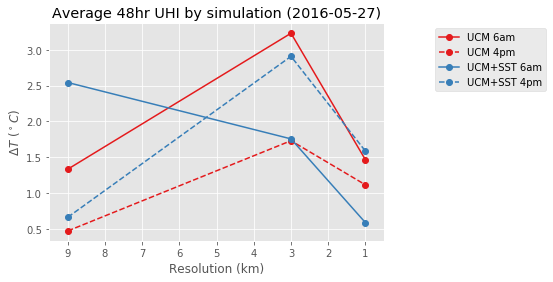

In [31]:
cmap = cm.get_cmap('Set1')
fig = plt.figure()
i = 0
for exp in ['UCM', 'UCM+SST']: 
    color = cmap(i)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_6am.values, 
            '-o', color = color, label = '%s 6am'%exp)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_4pm.values, 
            '--o',color = color,  label = '%s 4pm'%exp)
    i = i+1
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average 48hr UHI by simulation (%s)'%date)

We looked at the following experiments: 
UCM2D d01  contains 906 files
BEM2D+SST d01  contains 48 files
BEM2D+SST d02  contains 48 files
BEM2D+SST d03  contains 48 files
UCM2D+SST d01  contains 906 files

We compare BEM on May 25 with UCM on July 24 and see that: 

- UCM reproduces nighttime urban heating better than BEM2d
- UCM UHI intensities are highter than for BEM, even at a lower resolution
- Increasing resolution for BEM slightly decreases the daytime UHI intensity (prob. not significantly different, though)
- BEM shows negative UHI at 5 and 6 am ($T_r > T_u$)

('BEM2D+SST', 'd01')
('BEM2D+SST', 'd02')
('BEM2D+SST', 'd03')
('BEM2D', 'd01')
No data for BEM2D
('BEM2D', 'd02')
No data for BEM2D
('BEM2D', 'd03')
No data for BEM2D
('BEM+SST', 'd01')
No data for BEM+SST
('BEM+SST', 'd02')
No data for BEM+SST
('BEM+SST', 'd03')
No data for BEM+SST
('BEM', 'd01')
No data for BEM
('BEM', 'd02')
No data for BEM
('BEM', 'd03')
No data for BEM


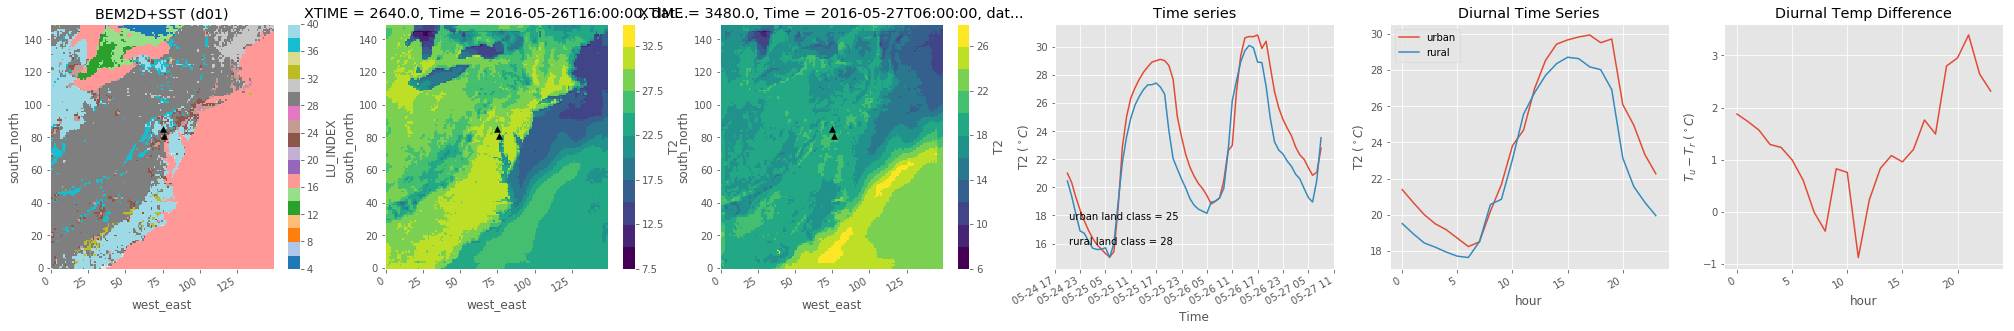

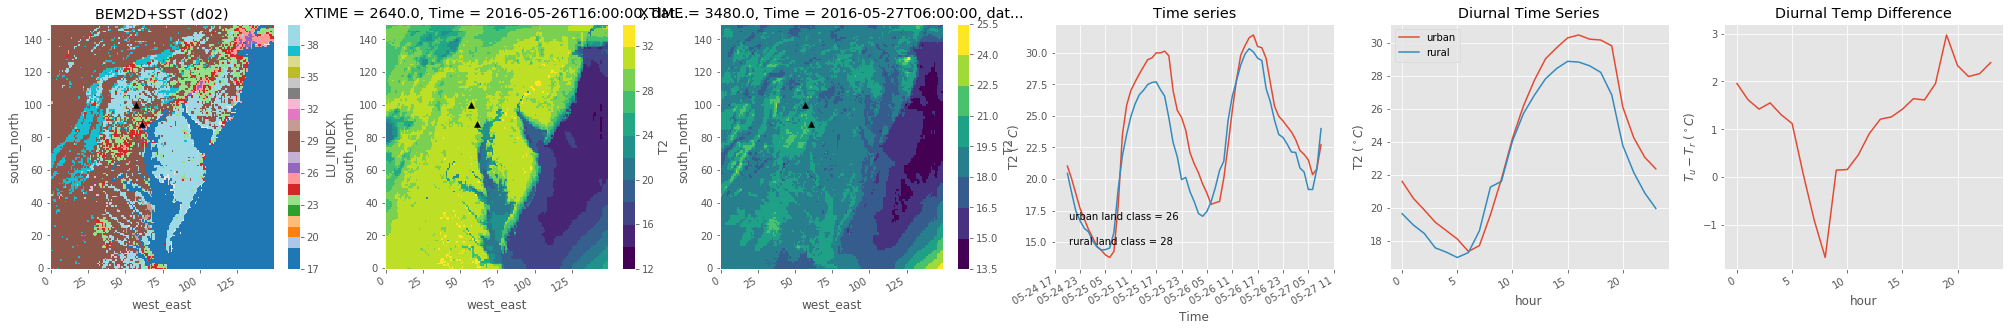

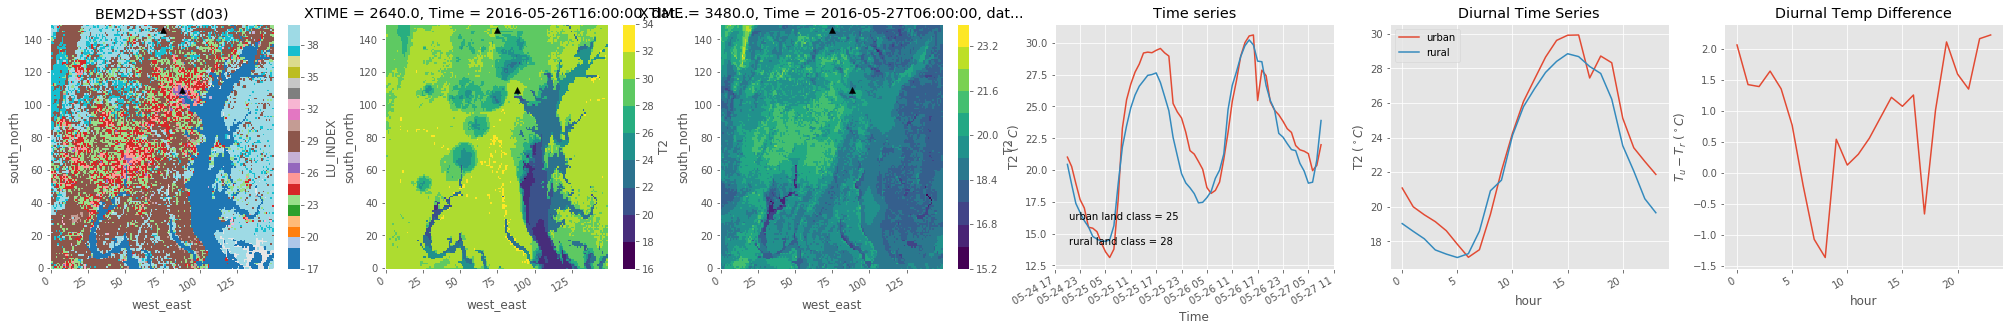

In [15]:
# do the same for 2 way nesting
dirs = os.listdir('/Users/ascott47/mountpoint/wrf/run/2way/')
#dom = 'd03'
date = '2016-05-27' 
# pts =pd.DataFrame([ [85,87],#west_east
#                    [140, 109] ]) # south_north
# rural analysis points; south_north = 140, west_east = 85
# urban analysis points: south_north = 109, west_east = 87])
for exp in dirs: 
    for dom in ['d01', 'd02','d03']: 
        print(exp, dom)
        files = list(np.sort(glob.glob('/Users/ascott47/mountpoint/wrf/run/2way/%s/wrfout_%s*'%(exp,dom))))
        if files:
        #files = list(np.sort(glob.glob(fpath+'%s/d01/wrfout_*'%exp)))
                # open dataset
            test_list = []
            for file in files:
                test_list.append(Dataset(file))
            df = getvar(test_list, varname = "T2", 
                          timeidx = wrf.ALL_TIMES, 
                          method = 'cat'
                          )
            # convert to degrees C
            df = df - 273.15
            # convert to local time
            df['Time'] = df['Time'] - pd.Timedelta('04:00:00')
            # select analysis points
            points = wrf.ll_to_xy(Dataset(file), analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            pts = wrf.ll_to_xy(test_list[-1],analysis_points['location:Latitude'], analysis_points['location:Longitude'])
            # points[0] is the lat coordinates
            # points[1] is the lon coordinate
            # urban, rural
            fig, axes = plt.subplots(ncols=6, figsize = [35,5])
            i = 0
            # plot landcover
            lc = getvar(test_list[-1], "LU_INDEX")
            lc.plot(levels = 24, cmap  = cm.tab20, ax = axes[i])
            axes[i].set_title('%s (%s)'%(exp, dom))
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map day 
            try: 
                df.sel(Time = date +'T16:00:00').plot(ax = axes[i], levels = 11)
            except: 
                df.sel(Time = '2016-05-26' +'T16:00:00').plot(ax = axes[i], levels = 11)
            #axes[i].set_title('Night (%s 4am)'%date)
            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # make map night 
            df.sel(Time = date+'T6:00:00').plot(ax = axes[i], levels = 11)

            axes[i].scatter(pts.values[0], pts.values[1], marker = '^', color = 'k')
            i = i+1
            # plot temp time series
    #         urban = df.isel(south_north= points.values[0][0], west_east = points.values[1][0])
    #         rural = df.isel(south_north= points.values[0][1], west_east = points.values[1][1])
            urban = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,0,0]
            rural = df.isel(west_east = pts.values[0], south_north = pts.values[1])[:,1,1]
            urban_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[0,0]
            rural_lc = lc.isel(west_east = pts.values[0], south_north = pts.values[1])[1,1]
            urban.plot(ax = axes[i])
            rural.plot(ax = axes[i])
            axes[i].set_title('Time series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            axes[i].annotate('urban land class = %i'%urban_lc,( .05,.2), xycoords = 'axes fraction')
            axes[i].annotate('rural land class = %i'%rural_lc,( .05,.1), xycoords = 'axes fraction')
            i = i+1
            # plot diurnal temp cycle
            urban.groupby('Time.hour').mean().plot(ax = axes[i], label = 'urban')
            rural.groupby('Time.hour').mean().plot(ax = axes[i], label = 'rural')
            axes[i].legend()
            axes[i].set_title('Diurnal Time Series')
            axes[i].set_ylabel('T2 ($^\circ C$)')
            i = i+1
            # plot DT in time
            (urban-rural).groupby('Time.hour').mean().plot(ax = axes[i])
            axes[i].set_ylabel('$T_u - T_r$ ($^\circ C$)')
            axes[i].set_title('Diurnal Temp Difference')
            
            uhi = (urban-rural).groupby('Time.hour').mean()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_6am'] =  uhi.sel(hour = 6).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_4pm'] =  uhi.sel(hour = 16).to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_max'] =  uhi.max().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'UHI_min'] =  uhi.min().to_pandas()
            uhidf.loc['%s_%s'%(exp,dom),'date'] =  df.Time[0].to_pandas()
            plt.savefig('figures/UHIbyExp/2waynest%s%s.png'%(exp, dom))
            
            df.close()
        else:  
            print('No data for %s'%exp)

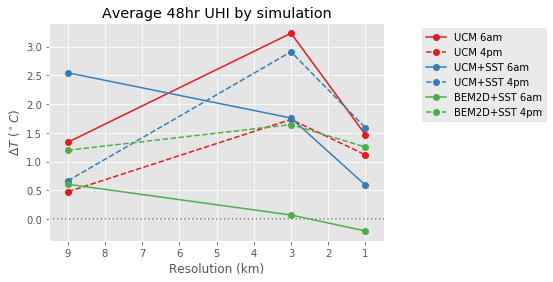

In [38]:
cmap = cm.get_cmap('Set1')
fig = plt.figure()
plt.axhline(0, color = 'gray', linestyle = ':')

i = 0
for exp in ['UCM', 'UCM+SST', 'BEM2D+SST']:#uhidf.exp.unique():#['UCM', 'UCM+SST']: 
    color = cmap(i)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_6am.values, 
            '-o', color = color, label = '%s 6am'%exp)
    plt.plot(uhidf[uhidf['exp']==exp].resolution.values, uhidf[uhidf['exp']==exp].UHI_4pm.values, 
            '--o',color = color,  label = '%s 4pm'%exp)
    i = i+1
plt.xlim([9.5, 0.5])
plt.xlabel('Resolution (km)')
plt.ylabel('$\Delta T$ ($^\circ C$)')
plt.legend(bbox_to_anchor=(1.5, 1),)
plt.title('Average 48hr UHI by simulation')
plt.savefig('plots/UHI_by_resolution.png', bbox_to_anchor = 'tight')

In [36]:
uhidf.head()

,UHI_6am,UHI_4pm,UHI_max,UHI_min,date,resolution,exp
Unnamed: 0,,,,,,,
UCM2D_d01,1.334641,0.473343,2.263535,-1.135330,2016-05-31T00:00:00.000000000,9.0,UCM2D
UCM2D_d02,3.230804,1.731689,3.230804,0.322220,2016-05-31T00:00:00.000000000,3.0,UCM2D
UCM_d01,1.334641,0.473343,2.263535,-1.135330,2016-05-31T00:00:00.000000000,9.0,UCM
UCM_d02,3.230804,1.731689,3.230804,0.322220,2016-05-31T00:00:00.000000000,3.0,UCM
UCM_d03,1.466293,1.116455,2.549835,-0.057556,2016-05-31T00:00:00.000000000,1.0,UCM


# Methodology 
I fixed a latitude and longitude point to represent the urban and rural location. For each run, I read in the landcover class and 2-meter temperature at that point for a 48 hour period (May 31-June 1 for one-way nested runs, May 25-27 for the two-way nested runs). I looked at the diurnal temperature cycle and then calculated the average UHI $T_u - T_r$ for that 48 hour period. Then, I looked at how UHI varies by resolution for UCM, UCM + SST, and BEM2D + SST runs. 

I briefly assessed the sensitivity of these findings to individual dates and didn't find dates where this was true. 


# Conclusions
In order to investigate how urban simulations capture Baltimore's UHI, we looked at the following experiments: 
UCM2D d01  contains 906 files
BEM2D+SST d01  contains 48 files
BEM2D+SST d02  contains 48 files
BEM2D+SST d03  contains 48 files
UCM2D+SST d01  contains 906 files


# One-way nesting

We compare BEM on May 25 with UCM on May 31 and see that: 

- UCM reproduces nighttime urban heating better than BEM2d
- UCM UHI intensities are highter than for BEM, even at a lower resolution
- Increasing resolution for BEM slightly decreases the daytime UHI intensity (prob. not significantly different, though)
- BEM shows negative UHI at 5 and 6 am ($T_r > T_u$)

# Two-way nesting
- The model reproduces daytime heating, but no nighttime UHI. 
- Increasing resolution changes the timing of the UHI diurnal cycle, buty has little impact on magitude
- In higher resolution runs, urban $T_{min}$ occurs later in the day than rural $T_{min}$

Highest UHI is for UCM2D+SST, which has $\Delta T_{min} = 3.5$ and $\Delta T_{max} = 4.5$ 

# Overall 
These simulations do not reproduce the phenomena of UHI being warmer at night. Only UCM runs (without SST update) show that UHI is greater at 6am than at 4pm. UHI increases for the 3 km runs, but decreases for the 1 km runs. 